<a href="https://colab.research.google.com/github/fclubb/EarthSurfaceProcesses/blob/master/Week3_FluvialIncision/Part3_SanGabrielMountains_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3: Channel steepness analysis of the San Gabriel Mountains, California



*This lesson has been written Fiona Clubb at Durham University, based on an original notebook by Simon M. Mudd at the University of Edinburgh*

Now we've had a look at some channel profiles and the stream power incision model, we are going to try to extract some channel profiles from a real landscape and explore how channel steepness varies across the landscape. You should be able to modify this notebook for different areas for use in your independent project, if you like.

We are going to be using the San Gabriel Mountains, California, as an example. Channel steepness has been found to increase non-linearly with erosion rates in this landscape (DiBiase et al., 2010).

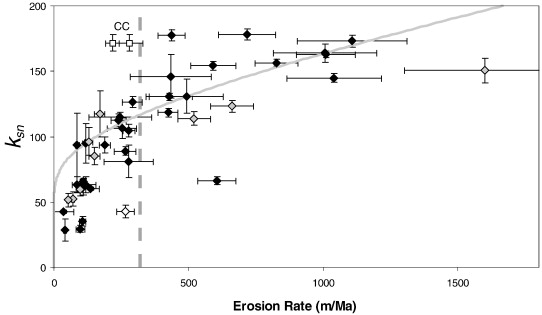 

Figure from DiBiase et al. (2010) - their Figure 7.

It would be helpful if you had a look at this paper before doing the practical:


---

*DiBiase, R.A., Whipple, K.X., Heimsath, A.M. and Ouimet, W.B., 2010. Landscape form and millennial erosion rates in the San Gabriel Mountains, CA. Earth and Planetary Science Letters, 289(1-2), pp.134-144. https://doi.org/10.1016/j.epsl.2009.10.036*

---



We're going to use a python package called `lsdviztools` to download a digital elevation model (DEM) with a resolution of 30 m. This is from the Shuttle Radar Topography Mission (SRTM): this DEM is available pretty much globally, so it's very useful for this module and potentially for your dissertation project.

We also will do a little bit of topographic analysis using **lsdtopotools**. **lsdtopotools** is a software package for analysing topography developed at the University of Edinburgh, Durham University, and other institutions. 

## Get the right python packages

In this first cell we're going to install `lsdtopotools` and `lsdviztools`. 
**WARNING - the first time you do this, it might take up to 5 minutes. Just wait for it to finish and then you don't have to run it again for the rest of the practical (even if you need to restart the kernel).**



In [1]:
!pip install lsdviztools &> /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lsdviztools-0.4.9-py2.py3-none-any.whl (271 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.6/757.6 kB 39.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 19.7 MB/s eta 0:00:00
  Using cached utm-0.7.0.tar.gz (8.7 kB)
  Preparing metadata (setup.py) .

Now we need to install lsdtopotools. We do this using something called `condacolab`. 

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

Now install `lsdtopotools`. The `&> /dev/null` bit just stops a bunch of rubbish being printed to the screen.

In [ ]:
!mamba install lsdtopotools &> /dev/null

## Import the packages that we need to the notebook

First check the version of lsdviztools. **For this notebook we need lsdviztools >=0.4.9**

In [ ]:
import lsdviztools
lsdviztools.__version__

In [ ]:
import lsdviztools.lsdmapwrappers as lsdmw
import lsdviztools.lsdbasemaptools as bmt
from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio

#pandas
import pandas as pd
import geopandas as gpd

#colab
from google.colab import files

#general
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
%matplotlib inline

## Now grab some data

First, we need to grab some data. We use a tool in `lsdviztools.lsdbasemaptools` called the `ot_scraper` (`ot` is for opentopography.org).

You can tell this what sort of data you want (most people will use the Copernicus 30 metre data) and you also tell it the lower left and the upper right corners, using latitude and longitude. You can get these from goole earth by right clicking on the map and selecting "what's here". In this example below, I will get the region for the San Gabriel Mountains. 

__MAKE SURE YOU HAVE UPLOADED YOUR API KEY TO GOOGLE COLAB AS A TEXT FILE BEFORE RUNNING THIS CODE BLOCK!!!__

In [ ]:
# YOU NEED TO PUT YOUR API KEY IN A FILE
OT_api_key_file = "OT_API_key.txt"

with open(OT_api_key_file, 'r') as file:
    print("I am reading you OT API key from the file "+ OT_api_key_file)
    api_key = file.read().rstrip()
    print("Your api key starts with: "+api_key[0:4])

# If you want to modify the DEM, change the bounding latitude and longitude. Change the `Dataset_prefix` if you want to change the name of the output DEM.
Dataset_prefix = "San_Gabriel"
SG_DEM = bmt.ot_scraper(source = "COP30",longitude_W = -118.257749, longitude_E = -117.488604, 
                            latitude_S = 34.143650, latitude_N =  34.404547, prefix = Dataset_prefix, api_key_file=OT_api_key_file)
SG_DEM.print_parameters()
SG_DEM.download_pythonic()

That just downloaded a .tif file, which you can find in the "Files" tab in Google Colab. If you like you can download it and look at in a GIS. 
You can also look at the raw data here in python using something called `rasterio`. 

But we will use some tools called **lsdtopotools** to look at the data. 

To do that, we need to convert the data into a format **lsdtopotools** can understand. 

The option below uses something called GDAL (short for Geospatial Data Abstraction Library). 
It has many tools for converting raster data formats and changing projections. It is also fast: it is much faster to convert or merge files using gdal than in, say, ArcMap. QGIS has the gdal tools built in. You can read more here: https://lsdtopotools.github.io/LSDTT_documentation/LSDTT_introduction_to_geospatial_data.html#translating-your-raster-into-something-that-can-be-used-by-lsdtopotoolbox

In the below line the main thing you would change is the zone: this is the UTM zone. You can look up your UTM zone here: http://www.dmap.co.uk/utmworld.htm

In [ ]:
import subprocess

# Below is the resolution of your data in metres
res = "30"

# Change the below UTM zone to the correct zone for your dataset (change the number after "+zone=")
pr = "+proj=utm +zone=10 +datum=WGS84"

# Dont change the stuff below this line
gd = "gdalwarp"
sr = "-t_srs"
of = "-of"
en = "ENVI"
ov = "-overwrite"
tr = "-tr"
r = "-r"
rm = "cubic"
infile = Dataset_prefix+"_COP30.tif"
outfile = Dataset_prefix+"_COP30_UTM.bil"

subprocess_list = [gd, sr, pr, of, en, ov, tr, res, res, r, rm, infile, outfile]

subprocess.run(subprocess_list)

# Below is the gdalwarp call that is not used but is here for future reference
#!gdalwarp -t_srs '+proj=utm +zone=30 +datum=WGS84' -of ENVI -overwrite Sorbas_SRTM30.tif Sorbas_SRTM30_UTM.bil

## Now we do some topographic analysis and look at the data

We will extract some topogaphic metrics using `lsdtopotools`, which we installed earlier in the notebook.

The `lsdtt_parameters` are the various parametes that you can use to run an analysis. We will discuss these later. For now, we will just follow this recipe. 

In [ ]:
lsdtt_parameters = {"write_hillshade" : "true",  
                    "surface_fitting_radius" : "60",
                    "print_slope" : "true"}
r_prefix = Dataset_prefix+"_COP30_UTM"
w_prefix = Dataset_prefix+"_COP30_UTM"
lsdtt_drive = lsdmw.lsdtt_driver(read_prefix = r_prefix,
                                 write_prefix= w_prefix,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()


In [ ]:
lsdtt_drive.run_lsdtt_command_line_tool()

That will take a little while to run (wait until there is a number in brackets beside the `In` to the right of the cell.)

It will spit out some files. If you want to see what files are in this directory after the cell has finished you can run the following cell:

In [ ]:
!ls

You will see that we have made some new rasters. We have made
* *San_Gabriel_SRTMGL1_UTM_hs*: a hillshade
* *San_Gabriel_SRTMGL1_UTM_SLOPE*: a slope raster




---


## Exercise 1

* Download the hillshade and the slope raster (each one is made of two files: one ending in `.bil` and one ending in `.hdr`. Open QGIS or ArcGIS and load the rasters (drag the `.bil` file into the window).

* Make a shaded slope map of the study area: to do this, load in both files and make sure the slope map is the top layer. Give the slope a transparency, say 50%, so you can see the hillshade through it.

* Explore the distribution of slopes across the study area. Write a short paragraph (2-3 sentences) to describe how slope changes across the region.

---




## Get some channel profiles

Okay, we will now run a different analysis which will allow us to get channel profiles for a range of drainage basins in the region.

In [ ]:
lsdtt_parameters = {"print_basin_raster" : "true",
                    "print_chi_data_maps" : "true",
                    "minimum_basin_size_pixels" : "5000"}
r_prefix = Dataset_prefix+"_COP30_UTM"
w_prefix = Dataset_prefix+"_COP30_UTM"
lsdtt_drive = lsdmw.lsdtt_driver(read_prefix = r_prefix,
                                 write_prefix= w_prefix,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()

In [ ]:
lsdtt_drive.run_lsdtt_command_line_tool()

Now let's run this code which makes a shapefile from the basins raster that we just calculated:

In [ ]:
# Get shapefile of basins from the raster
gio.PolygoniseRaster('./', Dataset_prefix+'_COP30_UTM_AllBasins.bil', OutputShapefile=Dataset_prefix+'_COP30_UTM_Basins.shp')

If you look at the files that we have created, you'll see that a number of new files now exist: The new files we've created are:


*   *San_Gabriel_SRTMGL1_UTM_AllBasins.bil* and *.hdr*: a raster showing you the basins that were extracted
*   *San_Gabriel_SRTMGL1_UTM_AllBasins.shp*: a shapefile of the basins
*   **San_Gabriel_SRTMGL1_UTM_chi_data_map.csv*: a CSV file with the information about the channel profiles. We will talk more about 'chi' profiles in a later practical. A CSV file can be loaded into Excel (although it will be really big, so I wouldn't recommend it). We can also load it in Python using a package called `geopandas`, which we'll do below.



You might have noticed that the basins shapefile has lots of different files that you need to download. You can run this code block to download them automatically (NOTE - WILL ONLY WORK WITH CHROME)

In [ ]:
files.download(Dataset_prefix+'_COP30_UTM_Basins.shp')
files.download(Dataset_prefix+'_COP30_UTM_Basins.dbf')
files.download(Dataset_prefix+'_COP30_UTM_Basins.prj')
files.download(Dataset_prefix+'_COP30_UTM_Basins.shx')
files.download(Dataset_prefix+'_COP30_UTM_Basins.cpg')



---


## Exercise 2

* Download the above files and load them into QGIS. You should be able to see the basins that we have extracted using the code. 

* Choose a basin that you are interested in and would like to explore further. This could be a basin that is very steep, for instance, or one that looks transient (has a variety of slopes within it). Make a note of the basin number by using the "Identify" tool. 

---



## Choose a basin for analysis
Now we are going to read in the channel data for a basin of your choice using geopandas. 

After this finishes running it will produce a csv file. 

These csv files can be read here, in the python environment. But they can also be loaded into a GIS by importing text data. You can make a file that is immediatly readable using a GIS by adding the option `convert_csv_to_geojson` to the parameters, so the command two cells up would become:

    lsdtt_parameters = {"print_basin_raster" : "true",
                        "print_chi_data_maps" : "true",
                        "convert_csv_to_geojson" : "true",
                        "minimum_basin_size_pixels" : "5000"}
                        
The disadvantage of this is that geojson files are much larger than csv. And you really only use these files with a GIS: if you use python you will be using the csv file. 

Okay, the cells below load a csv file using first `pandas` and then converts it into `geopandas` (which is `pandas` with georeferencing). This allows us to make what's called a `dataframe` (a data table, similar to Excel), in Python:

In [ ]:
chi_data_map_name = Dataset_prefix+"_COP30_UTM_chi_data_map.csv"
df = pd.read_csv(chi_data_map_name)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = "EPSG:4326" 
print(gdf.head())

We can use the following command to see what columns we have in our data table:

In [ ]:
gdf.columns

Let's use this dataframe to plot a river profile! You should have seen from looking at the basins in QGIS that we have lots of different basins. If you look at the raster in QGIS, you can see that they are assigned a number which is a bit random. You should have chosen one of these numbers in Exercise 2. To make it more logical, each basin is also assigned a "basin_key" which starts at 0 and goes up. You can see the basin key information in the file `San_Gabriel_SRTMGL1_UTM_AllBasinsInfo.csv`:

In [ ]:
basins_info = pd.read_csv(Dataset_prefix+'_COP30_UTM_AllBasinsInfo.csv')
basins_info

Let's choose a basin that we want to make a plot of using the basin key. If you want to change the basin, just change the basin key to another one from the table above.

In [ ]:
# set the basin key that you want to plot here
basin_key = 10

Then run the below cell to make a plot of the river profiles in that basin. We will make two plots: the first one is the entire river network, and the second one is the main stem only:

In [ ]:
# then do the plotting
plt.rcParams['figure.figsize'] = [10, 10]

# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == basin_key)]

# The main stem channel is the one with the minimum source key in this basin
min_source = np.amin(gdf_b1.source_key)
gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
#gdf_b2 = gdf_b1

# Create two subplots and unpack the output array immediately
plt.clf()
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter(gdf_b1['flow_distance'], gdf_b1['elevation'],c=gdf_b1['source_key'], s = 2)
ax2.scatter(gdf_b2['flow_distance'], gdf_b2['elevation'],s = 2)


ax1.set_xlabel("Distance from outlet (m)", fontsize=12)
ax1.set_ylabel("Elevation (m)", fontsize=12)
ax1.set_title('Full river network profile')

ax2.set_xlabel("Distance from outlet (m)", fontsize=12)
ax2.set_ylabel("Elevation (m)", fontsize=12)
ax2.set_title('Main stem profile')

plt.tight_layout()



---


## Exercise 3

* Use the table to find the basin key for the basin you chose in Exercise 2. Make a nice plot of the river profile for this basin. What features can you see in the profile? Are there any knickpoints (steepened reaches of the profile?)

* Write a short figure caption that describes the figure you have made, and explains the key of the river profile with reference to the slope map that you produced in Exercise 1.


---




## Getting the full channel profile with steepness information

In this section we are going to work with a file that has the extension `_MChiSegmented.csv`. 
To generate this file, you need to run the following command.

**Warning**: This is quite computationally expensive so if you have a big area it will take a while for this routine to finish. 

In [ ]:
command_line_tool = "lsdtt-chi-mapping"
lsdtt_parameters = {"print_segmented_M_chi_map_to_csv" : "true", 
                    "print_basin_raster" : "true",
                    "convert_csv_to_geojson" : "true"}

r_prefix = Dataset_prefix+"_COP30_UTM"
w_prefix = Dataset_prefix+"_COP30_UTM"
lsdtt_drive = lsdmw.lsdtt_driver(command_line_tool,read_prefix = r_prefix,
                                 write_prefix= w_prefix,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()
lsdtt_drive.run_lsdtt_command_line_tool()

We can use the `!ls` command to see if the file is there (the `!` tells the notebook to access the underlying linux operating system, and `ls` is a linux command that lists (`ls` is short for list) the contents of the current directory).

In [ ]:
!ls

Okay, the data is there, it is called `San_Gabriel_COP30_UTM_MChiSegmented.csv`. Lets load it with `geopandas`.

In [ ]:
segmented_data_map_name = w_prefix+"_MChiSegmented.csv"
df = pd.read_csv(segmented_data_map_name)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = "EPSG:4326" 
print(gdf.head())

Now let's look at the columns that are in our data table from this new analysis:

In [ ]:
gdf.columns

You can see that this dataset has a lot more information about the channel network! We have one column in particular, the `m_chi` column, which is very useful. This tells us **the steepness of the channel network at each point.** This is based on the $\chi$, or chi, analysis approach, which we covered in the lecture. You can think of this as being equivalent to $K_{sn}$ as calculated from slope-area plots.

Let's make our long profile plot again, but colour the channels by their steepness using the `m_chi` column. You can set the colour map that you want to use as the colours by changing the `cmap` parameter in the cell below. You can find a list of available colourmaps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [ ]:
# set the basin key that you want to plot here
basin_key = 10

In [ ]:
# choose the colourmap that you want to use.
cmap = cm.viridis

In [ ]:
# then do the plotting
plt.rcParams['figure.figsize'] = [10, 10]

# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == basin_key)]

# The main stem channel is the one with the minimum source key in this basin
min_source = np.amin(gdf_b1.source_key)
gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
#gdf_b2 = gdf_b1

# Create two subplots and unpack the output array immediately
plt.clf()
f, (ax1, ax2) = plt.subplots(2, 1)
c1 = ax1.scatter(gdf_b1['flow_distance'], gdf_b1['elevation'],c=gdf_b1['m_chi'], s = 2, cmap=cmap)
c2 = ax2.scatter(gdf_b2['flow_distance'], gdf_b2['elevation'],c=gdf_b2['m_chi'], s = 2, cmap=cmap)

ax1.set_xlabel("Distance from outlet (m)", fontsize=12)
ax1.set_ylabel("Elevation (m)", fontsize=12)
ax1.set_title('Full river network profile')

ax2.set_xlabel("Distance from outlet (m)", fontsize=12)
ax2.set_ylabel("Elevation (m)", fontsize=12)
ax2.set_title('Main stem profile')

# add colourbars to each axis
plt.colorbar(c1, cmap=cmap, ax=ax1, label = '$K_{sn}$')
plt.colorbar(c2, cmap=cmap, ax=ax2, label = '$K_{sn}$')

plt.tight_layout()

## Getting the average channel steepness of each basin

So how does channel steepness vary across the landscape? To examine this, we might want to calculate the mean channel steepness in each basin and then compare it to erosion rates, for example.

The cell below calculates the mean channel steepness in each basin, and writes it to a new shapefile with the outline of each basin. You can use QGIS to make nice plots where you colour the basin by the mean steepness.

In [ ]:
# group the dataframe by basin and get the mean steepness in each basin
mean_ksn = gdf.groupby('basin_key')['m_chi'].mean().reset_index()

# get the standard deviation of steepness within the basin
ksn_std = gdf.groupby('basin_key')['m_chi'].std().reset_index().rename(columns={'m_chi': 'm_chi_std'})

# merge with the csv file of the basin info
basins_info = pd.merge(basins_info, mean_ksn, on='basin_key')
basins_info = pd.merge(basins_info, ksn_std, on='basin_key')

In [ ]:
basins_info

In [ ]:
# read in the basin shapefile and merge with the csv file 
basin_gdf = gpd.read_file(Dataset_prefix+'_COP30_UTM_Basins.shp')
basin_gdf['ID'] = basin_gdf['ID'].astype('int64')
basin_gdf = basin_gdf.merge(basins_info, left_on='ID', right_on='outlet_junction').drop(columns='outlet_junction')

# write the geodataframe to shapefile
basin_gdf.to_file(Dataset_prefix+'_COP30_UTM_Basins_Ksn.shp')

In [ ]:
# download the shapefile
files.download(Dataset_prefix+'_COP30_UTM_Basins_Ksn.shp')
files.download(Dataset_prefix+'_COP30_UTM_Basins_Ksn.dbf')
files.download(Dataset_prefix+'_COP30_UTM_Basins_Ksn.prj')
files.download(Dataset_prefix+'_COP30_UTM_Basins_Ksn.cpg')
files.download(Dataset_prefix+'_COP30_UTM_Basins_Ksn.shx')


---

## Exercise 4

1. Download the shapefile of mean $K_{sn}$ for basins in the San Gabriel Mountains. Load into QGIS (or ArcGIS if you prefer) and make a map plot of the basins coloured by $K_{sn}$, with the hillshade underneath (hint - the column is called `m_chi` in the attribute table).
Add the channel network onto the plot: to do this, download the file `San_Gabriel_COP30_UTM_MChiSegmented.geojson`, and add into the GIS by dragging and dropping. You can colour this by `m_chi` to look at how channel steepness varies within a basin.

---
**TIP:** To add a GeoJSON to ArcGIS Pro: use the `JSON to Features (Conversion)
` tool. Choose the file `San_Gabriel_COP30_UTM_MChiSegmented.geojson` as the input, and give your feature class an appropriate name. Select `Points` as the Geometry type.

---

2. Look at the spatial pattern of $K_{sn}$ across the region. How does it compare to the erosion rate data DiBiase et al. (2010)?. Make a figure that compares the basin-averaged $K_{sn}$  to the erosion rates from the below figure. Write a short caption that explains how they compare. The erosion rate data are shown in Figure 1 of that paper:
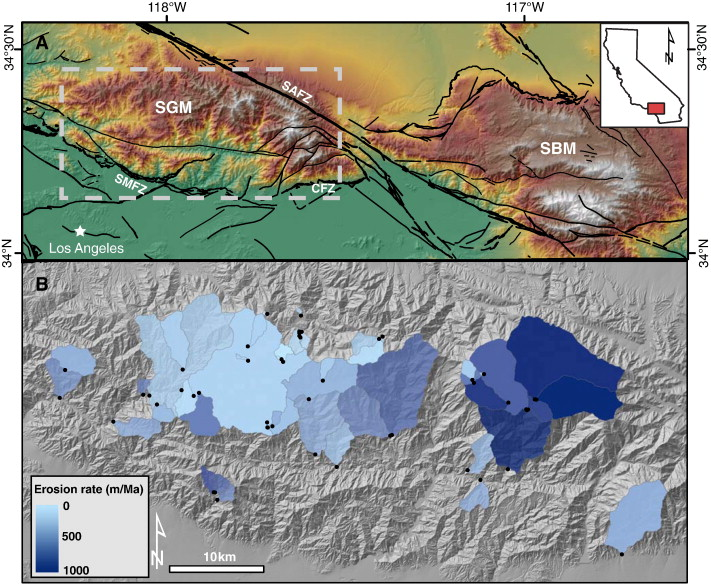

Figure from DiBiase et al., 2010, EPSL.


3. What are the differences between the basin-averaged $K_{sn}$ and the $K_{sn}$ values for the actual channel network? How variable do you think $K_{sn}$ is within a basin? BONUS - which column from the basin + $K_{sn}$ shapefile could be used to illustrate variability within basin?